# Baseline model 
The baseline is a Logistic Regression classifier trained on handcrafted ECG features: mean heart rate, variance of R-R intervals, QRS width/amplitude, and T-wave presence. These features are commonly used in clinical ECG analysis and can be easily incorporated into scikit-learn. This provides a benchmark which my deep learning model can be compared to.

In [2]:
%pip install wfdb

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from scipy import signal
from scipy.interpolate import interp1d
import torch
from torchvision import datasets, models
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import wfdb
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

#### Preprocessing Functions

In [18]:
PTB_PATH = "C:/Users/sharm/OneDrive/Desktop/Ece344/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/"
MITDB_PATH = "C:/Users/sharm/OneDrive/Desktop/Ece344/mit-bih-arrhythmia-database-1.0.0/mit-bih-arrhythmia-database-1.0.0/" 
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
FEATURE_NAMES = [
    'mean_hr', 'rr_variance', 'mean_rr', 'sdnn', 'rmssd',
    'qrs_width_mean', 'qrs_amplitude_mean', 
    'signal_mean', 'signal_std', 'signal_max'
]

def bandpass_filter(ecg_signal, lowcut=0.5, highcut=40, fs=100, order=4):
    """
    Apply bandpass filter (0.5-40 Hz) to remove baseline drift and noise.
    
    Args:
        ecg_signal: 1D numpy array of ECG signal
        lowcut: Low frequency cutoff (Hz)
        highcut: High frequency cutoff (Hz)
        fs: Sampling frequency (Hz)
        order: Filter order
        
    Returns:
        filtered_signal: Filtered ECG signal
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    filtered_signal = signal.filtfilt(b, a, ecg_signal)
    return filtered_signal

def normalize_zscore(ecg_signal):
    """
    Apply Z-score normalization for consistent amplitude scaling.
    
    Args:
        ecg_signal: 1D numpy array
        
    Returns:
        normalized_signal: Z-score normalized signal
    """
    mean = np.mean(ecg_signal)
    std = np.std(ecg_signal)
    if std == 0:
        return ecg_signal - mean
    return (ecg_signal - mean) / std

def segment_ecg(ecg_signal, window_size=10, fs=100):
    """
    Split ECG into fixed-length windows.
    
    Args:
        ecg_signal: 1D numpy array
        window_size: Window length in seconds
        fs: Sampling frequency
        
    Returns:
        segments: List of ECG segments
    """
    samples_per_window = window_size * fs
    num_windows = len(ecg_signal) // samples_per_window
    segments = []
    
    for i in range(num_windows):
        start_idx = i * samples_per_window
        end_idx = start_idx + samples_per_window
        segments.append(ecg_signal[start_idx:end_idx])
    
    return segments

def resample_signal(ecg_signal, original_fs=360, target_fs=100):
    """
    Resample signal from original_fs to target_fs.
    
    Args:
        ecg_signal: 1D numpy array
        original_fs: Original sampling frequency
        target_fs: Target sampling frequency
        
    Returns:
        resampled_signal: Resampled ECG signal
    """
    original_time = np.arange(len(ecg_signal)) / original_fs
    target_samples = int(len(ecg_signal) * target_fs / original_fs)
    target_time = np.arange(target_samples) / target_fs
    
    interpolator = interp1d(original_time, ecg_signal, kind='linear', fill_value='extrapolate')
    resampled_signal = interpolator(target_time)
    
    return resampled_signal

def detect_r_peaks(ecg_signal, fs=100):
    """
    Detect R-peaks in ECG signal.
    
    Args:
        ecg_signal: 1D numpy array
        fs: Sampling frequency
        
    Returns:
        peaks: Indices of detected R-peaks
    """
    b, a = signal.butter(2, [5, 15], btype='band', fs=fs)
    filtered = signal.filtfilt(b, a, ecg_signal)
    peaks, _ = signal.find_peaks(filtered, distance=fs*0.5, prominence=0.3)
    return peaks

def extract_ecg_features(ecg_signal, fs=100):
    """
    Extract handcrafted ECG features.
    
    Args:
        ecg_signal: ECG signal (can be multi-lead)
        fs: Sampling frequency
        
    Returns:
        features: Dictionary of extracted features
    """
    features = {}
    
    # Use single lead
    signal_lead = ecg_signal[:, 0] if ecg_signal.ndim > 1 else ecg_signal
    
    # Detect R-peaks
    r_peaks = detect_r_peaks(signal_lead, fs)
    
    if len(r_peaks) < 2:
        return {
            'mean_hr': 0, 'rr_variance': 0, 'mean_rr': 0,
            'sdnn': 0, 'rmssd': 0, 
            'qrs_width_mean': 0, 'qrs_amplitude_mean': 0,
            'signal_mean': np.mean(signal_lead),
            'signal_std': np.std(signal_lead),
            'signal_max': np.max(signal_lead)
        }
    
    # R-R intervals
    rr_intervals = np.diff(r_peaks) / fs
    
    # Heart rate features
    features['mean_hr'] = 60 / np.mean(rr_intervals)
    features['rr_variance'] = np.var(rr_intervals)
    features['mean_rr'] = np.mean(rr_intervals)
    features['sdnn'] = np.std(rr_intervals)
    features['rmssd'] = np.sqrt(np.mean(np.diff(rr_intervals) ** 2))
    
    # QRS features
    qrs_widths = []
    qrs_amplitudes = []
    
    for peak in r_peaks:
        start = max(0, peak - int(0.08 * fs))
        end = min(len(signal_lead), peak + int(0.08 * fs))
        qrs_segment = signal_lead[start:end]
        qrs_widths.append((end - start) / fs)
        qrs_amplitudes.append(np.max(qrs_segment) - np.min(qrs_segment))
    
    features['qrs_width_mean'] = np.mean(qrs_widths)
    features['qrs_amplitude_mean'] = np.mean(qrs_amplitudes)
    
    # Signal statistics
    features['signal_mean'] = np.mean(signal_lead)
    features['signal_std'] = np.std(signal_lead)
    features['signal_max'] = np.max(signal_lead)
    
    return features


#### Data Loading

In [6]:
class ECGFeatureDataset(Dataset):
    """Dataset for ECG features and labels."""
    
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = labels
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

def aggregate_diagnostic(y_dic, agg_df):
    """
    Map PTB-XL diagnostic codes to our 4 target classes.
    
    Args:
        y_dic: Dictionary of diagnostic codes from PTB-XL
        agg_df: Dataframe with diagnostic mappings
        
    Returns:
        List of target class labels
    """
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            cls = agg_df.loc[key].diagnostic_class
            if cls == 'NORM':
                tmp.append('Normal')
            elif cls == 'MI':
                tmp.append('MI')
            elif 'AFIB' in key or 'AFLT' in key:
                tmp.append('AFib')
            elif cls == 'CD':
                tmp.append('BBB')
    return list(set(tmp))

def map_mitdb_annotation(symbol):
    """
    Map MIT-BIH beat annotations to our 4 target classes.
    
    Args:
        symbol: MIT-BIH annotation symbol
        
    Returns:
        Class label or None
    """
    if symbol in ['N', 'L', 'R', 'e', 'j']:
        return 'Normal'
    elif symbol in ['A', 'a', 'J', 'S']:
        return 'AFib'
    elif symbol in ['V', 'E']:
        return 'MI'
    elif symbol in ['R', 'L']:
        return 'BBB'
    return None
def load_ptbxl_data():
    """
    Load and preprocess PTB-XL dataset sequentially (safe for VS Code / Windows).
    """
    print("\n" + "=" * 80)
    print("LOADING PTB-XL DATASET")
    print("=" * 80)
    

    ptb_data = pd.read_csv(PTB_PATH + 'ptbxl_database.csv', index_col='ecg_id')
    ptb_data.scp_codes = ptb_data.scp_codes.apply(lambda x: eval(x))
    print(f"Loaded {len(ptb_data)} records")
    

    agg_df = pd.read_csv(PTB_PATH + 'scp_statements.csv', index_col=0)
    agg_df = agg_df[agg_df.diagnostic == 1]
    
    # Map to our 4 classes
    ptb_data['target_class'] = ptb_data.scp_codes.apply(lambda x: aggregate_diagnostic(x, agg_df))
    ptb_filtered = ptb_data[ptb_data.target_class.apply(lambda x: len(x) == 1)]
    ptb_filtered['label'] = ptb_filtered.target_class.apply(lambda x: x[0])
    
    print(f"Filtered to {len(ptb_filtered)} single-label records")
    print("\nClass distribution:")
    print(ptb_filtered['label'].value_counts())
    
    print("\nProcessing signals...")
    features, labels = [], []
    
    for idx, row in ptb_filtered.iterrows():
        try:
            filename = row['filename_lr']
            record = wfdb.rdrecord(PTB_PATH + filename)
            ecg_signal = record.p_signal
            lead_signal = ecg_signal[:, 0]
            
            filtered = bandpass_filter(lead_signal, fs=100)
            normalized = normalize_zscore(filtered)
            segments = segment_ecg(normalized, window_size=10, fs=100)
            
            for segment in segments:
                feat = extract_ecg_features(segment, fs=100)
                features.append(list(feat.values()))
                labels.append(row['label'])
            
            if len(features) % 1000 == 0:
                print(f"  Processed {len(features)} segments...")
                
        except Exception as e:
            continue
    
    print(f"✓ PTB-XL complete: {len(features)} segments")
    return features, labels
def load_mitdb_data():
    """
    Load and preprocess MIT-BIH dataset 
    
    Returns:
        features: List of feature vectors
        labels: List of labels
    """
    print("\n" + "=" * 80)
    print("LOADING MIT-BIH DATASET")
    print("=" * 80)
    
    mitdb_records = [
        '100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
        '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
        '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
        '209', '210', '212', '213', '214', '215', '217', '219', '220', '221',
        '222', '223', '228', '230', '231', '232', '233', '234'
    ]
    
    print("Processing signals...")
    features = []
    labels = []
    
    for record_name in mitdb_records:
        try:
            record = wfdb.rdrecord(MITDB_PATH + record_name)
            annotation = wfdb.rdann(MITDB_PATH + record_name, 'atr')
            
            ecg_signal = record.p_signal[:, 0]
            resampled = resample_signal(ecg_signal, original_fs=360, target_fs=100)
            filtered = bandpass_filter(resampled, fs=100)
            normalized = normalize_zscore(filtered)
            r_peaks = detect_r_peaks(normalized, fs=100)
            
            window_samples = 10 * 100
            
            
            annotation_samples = np.array(annotation.sample)
            annotation_symbols = np.array(annotation.symbol)
            
            for peak in r_peaks[::5]:
                start = max(0, peak - window_samples // 2)
                end = min(len(normalized), peak + window_samples // 2)
                
                if end - start == window_samples:
                    segment = normalized[start:end]
                    
                    start_sample_original = int(start * 360 / 100)
                    end_sample_original = int(end * 360 / 100)
                    
                    mask = (annotation_samples >= start_sample_original) & \
                           (annotation_samples < end_sample_original)
                    segment_annotations = annotation_symbols[mask]
                    
                    if len(segment_annotations) > 0:
                        unique, counts = np.unique(segment_annotations, return_counts=True)
                        dominant_annotation = unique[np.argmax(counts)]
                        label = map_mitdb_annotation(dominant_annotation)
                        
                        if label:
                            feat = extract_ecg_features(segment, fs=100)
                            features.append(list(feat.values()))
                            labels.append(label)
            
            if len(features) % 500 == 0:
                print(f"  Processed {len(features)} segments...")
                
        except Exception as e:
            print(f"ERROR on MIT-BIH record {record_name}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    print(f"✓ MIT-BIH complete: {len(features)} segments")
    return features, labels

In [7]:
def get_data_loaders(features, labels, batch_size=64):
    """
    Create train/val/test data loaders with random sampling.
    
    Args:
        features: numpy array of features
        labels: numpy array of labels
        batch_size: batch size for data loaders
        
    Returns:
        train_loader: training data loader
        val_loader: validation data loader
        test_loader: test data loader
        classes: list of class names
    """
   
    dataset = ECGFeatureDataset(features, labels)
    
    
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(indices)
    
    train_split = int(0.7 * dataset_size)
    val_split = int(0.85 * dataset_size)
    
    train_indices = indices[:train_split]
    val_indices = indices[train_split:val_split]
    test_indices = indices[val_split:]
    
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    test_sampler = SubsetRandomSampler(test_indices)
   
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
   
    classes = list(set(labels))
    
    print(f"\nDataset split:")
    print(f"  Training: {len(train_indices)} samples ({len(train_indices)/dataset_size*100:.1f}%)")
    print(f"  Validation: {len(val_indices)} samples ({len(val_indices)/dataset_size*100:.1f}%)")
    print(f"  Test: {len(test_indices)} samples ({len(test_indices)/dataset_size*100:.1f}%)")
    
    return train_loader, val_loader, test_loader, classes, train_indices, val_indices, test_indices


In [8]:
ptb_features, ptb_labels = load_ptbxl_data()
mitdb_features, mitdb_labels = load_mitdb_data()

X_all = np.array(ptb_features + mitdb_features)
y_all = np.array(ptb_labels + mitdb_labels)

print(f"Total samples: {len(X_all)}")
print(f"  PTB-XL: {len(ptb_features)}")
print(f"  MIT-BIH: {len(mitdb_features)}")
print(f"\nClass distribution:")
unique, counts = np.unique(y_all, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"  {cls}: {cnt} ({cnt/len(y_all)*100:.1f}%)")

train_loader, val_loader, test_loader, classes, train_idx, val_idx, test_idx = get_data_loaders(
    X_all, y_all, batch_size=64
)

X_train = X_all[train_idx]
y_train = y_all[train_idx]
X_val = X_all[val_idx]
y_val = y_all[val_idx]
X_test = X_all[test_idx]
y_test = y_all[test_idx]


LOADING PTB-XL DATASET
Loaded 21837 records


C:\Users\sharm\AppData\Local\Temp\ipykernel_13524\3386350937.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ptb_filtered['label'] = ptb_filtered.target_class.apply(lambda x: x[0])


Filtered to 15490 single-label records

Class distribution:
label
Normal    9113
MI        3685
BBB       2692
Name: count, dtype: int64

Processing signals...
  Processed 1000 segments...
  Processed 2000 segments...
  Processed 3000 segments...
  Processed 4000 segments...
  Processed 5000 segments...
  Processed 6000 segments...
  Processed 7000 segments...
  Processed 8000 segments...
  Processed 9000 segments...
  Processed 10000 segments...
  Processed 11000 segments...
  Processed 12000 segments...
  Processed 13000 segments...
  Processed 14000 segments...
  Processed 15000 segments...
✓ PTB-XL complete: 15490 segments

LOADING MIT-BIH DATASET
Processing signals...
✓ MIT-BIH complete: 19695 segments
Total samples: 35185
  PTB-XL: 15490
  MIT-BIH: 19695

Class distribution:
  AFib: 476 (1.4%)
  BBB: 2692 (7.7%)
  MI: 4058 (11.5%)
  Normal: 27959 (79.5%)

Dataset split:
  Training: 24629 samples (70.0%)
  Validation: 5278 samples (15.0%)
  Test: 5278 samples (15.0%)


#### Training the baseline

In [9]:
print("\n" + "=" * 80)
print("TRAINING BASELINE MODEL")
print("=" * 80)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED, 
                          multi_class='multinomial', solver='lbfgs')

print("Training Logistic Regression...")
start_time = time.time()
model.fit(X_train_scaled, y_train)
train_time = time.time() - start_time

print(f"✓ Training complete ({train_time:.2f}s)")


y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
train_f1 = f1_score(y_train, y_pred_train, average='weighted')
test_f1 = f1_score(y_test, y_pred_test, average='weighted')

print(f"\nResults:")
print(f"  Train Accuracy: {train_acc:.4f}")
print(f"  Test Accuracy: {test_acc:.4f}")
print(f"  Train F1: {train_f1:.4f}")
print(f"  Test F1: {test_f1:.4f}")

print("\n" + classification_report(y_test, y_pred_test))


TRAINING BASELINE MODEL
Training Logistic Regression...
✓ Training complete (0.16s)

Results:
  Train Accuracy: 0.7999
  Test Accuracy: 0.8007
  Train F1: 0.7149
  Test F1: 0.7158

              precision    recall  f1-score   support

        AFib       0.93      0.47      0.63        78
         BBB       0.00      0.00      0.00       414
          MI       0.00      0.00      0.00       590
      Normal       0.80      1.00      0.89      4196

    accuracy                           0.80      5278
   macro avg       0.43      0.37      0.38      5278
weighted avg       0.65      0.80      0.72      5278



c:\Users\sharm\OneDrive\Desktop\Ece344\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\sharm\OneDrive\Desktop\Ece344\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\sharm\OneDrive\Desktop\Ece344\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\U

# Actual Model: 

In [10]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU'}")

CUDA available: True
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


#### Supporting Functions

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder

def load_ptbxl_signals():
    """Load PTB-XL raw signals for CNN-Transformer."""
    print("\n" + "=" * 80)
    print("LOADING PTB-XL RAW SIGNALS")
    print("=" * 80)
    
    ptb_data = pd.read_csv(PTB_PATH + 'ptbxl_database.csv', index_col='ecg_id')
    ptb_data.scp_codes = ptb_data.scp_codes.apply(lambda x: eval(x))
    
    agg_df = pd.read_csv(PTB_PATH + 'scp_statements.csv', index_col=0)
    agg_df = agg_df[agg_df.diagnostic == 1]
    
    ptb_data['target_class'] = ptb_data.scp_codes.apply(lambda x: aggregate_diagnostic(x, agg_df))
    ptb_filtered = ptb_data[ptb_data.target_class.apply(lambda x: len(x) == 1)].copy() 
    ptb_filtered['label'] = ptb_filtered.target_class.apply(lambda x: x[0])
    
    print(f"Processing {len(ptb_filtered)} records...")
    signals, labels = [], []
    
    for idx, row in ptb_filtered.iterrows():
        try:
            filename = row['filename_lr']
            record = wfdb.rdrecord(PTB_PATH + filename)
            ecg_signal = record.p_signal
            lead_signal = ecg_signal[:, 0]
            
            filtered = bandpass_filter(lead_signal, fs=100)
            normalized = normalize_zscore(filtered)
            segments = segment_ecg(normalized, window_size=10, fs=100)
            
            for segment in segments:
                signals.append(segment)
                labels.append(row['label'])
            
            if len(signals) % 1000 == 0:
                print(f"  Processed {len(signals)} segments...")
                
        except Exception as e:
            print(f"ERROR on PTB-XL record {idx}: {e}")
            continue
    
    print(f"✓ PTB-XL complete: {len(signals)} segments")
    return signals, labels

def load_mitdb_signals():
    """Load MIT-BIH raw signals for CNN-Transformer"""
    print("\n" + "=" * 80)
    print("LOADING MIT-BIH RAW SIGNALS")
    print("=" * 80)
    
    mitdb_records = [
        '100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
        '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
        '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
        '209', '210', '212', '213', '214', '215', '217', '219', '220', '221',
        '222', '223', '228', '230', '231', '232', '233', '234'
    ]
    
    print("Processing signals...")
    signals, labels = [], []
    
    for record_name in mitdb_records:
        try:
            record = wfdb.rdrecord(MITDB_PATH + record_name)
            annotation = wfdb.rdann(MITDB_PATH + record_name, 'atr')
            
            ecg_signal = record.p_signal[:, 0]
            resampled = resample_signal(ecg_signal, original_fs=360, target_fs=100)
            filtered = bandpass_filter(resampled, fs=100)
            normalized = normalize_zscore(filtered)
            r_peaks = detect_r_peaks(normalized, fs=100)
            
            window_samples = 10 * 100
            
            for peak in r_peaks[::5]:
                start = max(0, peak - window_samples // 2)
                end = min(len(normalized), peak + window_samples // 2)
                
                if end - start == window_samples:
                    segment = normalized[start:end]
                    
                    start_sample_original = int(start * 360 / 100)
                    end_sample_original = int(end * 360 / 100)
                    
                    annotation_samples = np.array(annotation.sample)
                    annotation_symbols = np.array(annotation.symbol)
                    
                    mask = (annotation_samples >= start_sample_original) & (annotation_samples < end_sample_original)
                    segment_annotations = annotation_symbols[mask]
                    
                    if len(segment_annotations) > 0:
                        unique, counts = np.unique(segment_annotations, return_counts=True)
                        dominant_annotation = unique[np.argmax(counts)]
                        label = map_mitdb_annotation(dominant_annotation)
                        
                        if label:
                            signals.append(segment)
                            labels.append(label)
            
            if len(signals) % 500 == 0:
                print(f"  Processed {len(signals)} segments...")
                
        except Exception as e:
            print(f"ERROR on MIT-BIH record {record_name}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    print(f"✓ MIT-BIH complete: {len(signals)} segments")
    return signals, labels

class ECGSignalDataset(Dataset):
    """Dataset with STRONGER augmentation."""
    
    def __init__(self, signals, labels, label_encoder, augment=False):
        self.signals = torch.FloatTensor(signals).unsqueeze(1)
        self.labels = torch.LongTensor(label_encoder.transform(labels))
        self.augment = augment
    def __len__(self):  
        return len(self.signals)
    def __getitem__(self, idx):
        signal = self.signals[idx]
        
        if self.augment:
            noise = torch.randn_like(signal) * 0.1  
            signal = signal + noise
            
            scale = torch.FloatTensor(1).uniform_(0.8, 1.2)
            signal = signal * scale
            
            shift = torch.randint(-50, 50, (1,)).item()
            signal = torch.roll(signal, shifts=shift, dims=-1)
            
            # 4. Random baseline wander (NEW!)
            if torch.rand(1).item() > 0.5:
                baseline = torch.sin(torch.arange(signal.size(-1)) * 0.01) * 0.05
                signal = signal + baseline.view(1, -1)
        
        return signal, self.labels[idx]

class CNNTransformerECG(nn.Module):
    """CNN-Transformer for ECG classification."""
    
    def __init__(self, num_classes=4):
        super(CNNTransformerECG, self).__init__()
    
        self.conv1 = nn.Conv1d(1, 64, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)
        
        self.conv2 = nn.Conv1d(64, 128, kernel_size=7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)
        
        self.conv3 = nn.Conv1d(128, 256, kernel_size=7, padding=3)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(2)
        
        self.sequence_length = 125
        self.d_model = 256

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.d_model,
            nhead=8,
            dim_feedforward=512,
            dropout=0.2,  
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.fc1 = nn.Linear(self.d_model * self.sequence_length, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        
        x = x.permute(0, 2, 1)
        x = self.transformer(x)
       
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

def get_model_name(name, batch_size, learning_rate, epoch):
    """Generate model name."""
    return f"model_{name}_bs{batch_size}_lr{learning_rate}_epoch{epoch}"

def train(model, train_loader, val_loader, num_epochs=20, learning_rate=0.0001, batch_size=32, name="cnn_transformer"):
    """Train CNN-Transformer model."""
    torch.manual_seed(RANDOM_SEED)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"Using device: {device}")
    
    print("Training Started...")
    
    for epoch in range(num_epochs):
       
        model.train()
        total_train_loss = 0.0
        total_train_err = 0.0
        total_samples = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total_train_err += (preds != labels).sum().item()
            total_samples += labels.size(0)
        
        train_loss[epoch] = total_train_loss / len(train_loader)
        train_err[epoch] = total_train_err / total_samples
       
        model.eval()
        val_total_loss = 0.0
        val_total_err = 0.0
        val_samples = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_total_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_total_err += (preds != labels).sum().item()
                val_samples += labels.size(0)
        
        val_loss[epoch] = val_total_loss / len(val_loader)
        val_err[epoch] = val_total_err / val_samples
        
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss[epoch]:.4f} | "
              f"Val Loss: {val_loss[epoch]:.4f} | "
              f"Train Err: {train_err[epoch]*100:.2f}% | "
              f"Val Err: {val_err[epoch]*100:.2f}%")
        
        model_path = get_model_name(name, batch_size, learning_rate, epoch+1)
        torch.save(model.state_dict(), model_path + ".pth")
    
    model_path = get_model_name(name, batch_size, learning_rate, num_epochs)
    np.savetxt(f"{model_path}_train_err.csv", train_err)
    np.savetxt(f"{model_path}_val_err.csv", val_err)
    np.savetxt(f"{model_path}_train_loss.csv", train_loss)
    np.savetxt(f"{model_path}_val_loss.csv", val_loss)
    
    return train_err, val_err, train_loss, val_loss

def plot_training_curve(path):
    """Plot training curves."""
    train_err = np.loadtxt(f"{path}_train_err.csv")
    val_err = np.loadtxt(f"{path}_val_err.csv")
    train_loss = np.loadtxt(f"{path}_train_loss.csv")
    val_loss = np.loadtxt(f"{path}_val_loss.csv")
    
    n = len(train_err)
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, n+1), train_err, label='Train Error')
    plt.plot(range(1, n+1), val_err, label='Validation Error')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.title('Train vs Validation Error')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, n+1), train_loss, label='Train Loss')
    plt.plot(range(1, n+1), val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def get_dl_data_loaders(signals, labels, batch_size=32):
    """Create data loaders with augmentation for training."""
    label_encoder = LabelEncoder()
    label_encoder.fit(labels)
    
    dataset_size = len(signals)
    indices = list(range(dataset_size))
    np.random.seed(RANDOM_SEED)
    np.random.shuffle(indices)
    
    train_split = int(0.7 * dataset_size)
    val_split = int(0.85 * dataset_size)
    
    train_indices = indices[:train_split]
    val_indices = indices[train_split:val_split]
    test_indices = indices[val_split:]
    
    train_signals = [signals[i] for i in train_indices]
    train_labels = [labels[i] for i in train_indices]
    train_dataset = ECGSignalDataset(train_signals, train_labels, label_encoder, augment=True)
    
    val_signals = [signals[i] for i in val_indices]
    val_labels = [labels[i] for i in val_indices]
    val_dataset = ECGSignalDataset(val_signals, val_labels, label_encoder, augment=False)
    
    test_signals = [signals[i] for i in test_indices]
    test_labels = [labels[i] for i in test_indices]
    test_dataset = ECGSignalDataset(test_signals, test_labels, label_encoder, augment=False)
 
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"Dataset split: {len(train_indices)}/{len(val_indices)}/{len(test_indices)}")
    return train_loader, val_loader, test_loader, label_encoder


#### Training the model


LOADING PTB-XL RAW SIGNALS
Processing 15490 records...
  Processed 1000 segments...
  Processed 2000 segments...
  Processed 3000 segments...
  Processed 4000 segments...
  Processed 5000 segments...
  Processed 6000 segments...
  Processed 7000 segments...
  Processed 8000 segments...
  Processed 9000 segments...
  Processed 10000 segments...
  Processed 11000 segments...
  Processed 12000 segments...
  Processed 13000 segments...
  Processed 14000 segments...
  Processed 15000 segments...
✓ PTB-XL complete: 15490 segments

LOADING MIT-BIH RAW SIGNALS
Processing signals...
✓ MIT-BIH complete: 19695 segments

Total: 35185 signals


C:\Users\sharm\AppData\Local\Temp\ipykernel_13524\3574003805.py:122: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  self.signals = torch.FloatTensor(signals).unsqueeze(1)


Dataset split: 24629/5278/5278
Model parameters: 5,439,364
Using device: cuda
Training Started...
Epoch 1/20 | Train Loss: 0.5728 | Val Loss: 0.4395 | Train Err: 18.82% | Val Err: 15.99%
Epoch 2/20 | Train Loss: 0.4514 | Val Loss: 0.3814 | Train Err: 15.73% | Val Err: 13.49%
Epoch 3/20 | Train Loss: 0.4016 | Val Loss: 0.3767 | Train Err: 14.13% | Val Err: 13.38%
Epoch 4/20 | Train Loss: 0.3821 | Val Loss: 0.4348 | Train Err: 13.42% | Val Err: 15.23%
Epoch 5/20 | Train Loss: 0.3634 | Val Loss: 0.5085 | Train Err: 12.98% | Val Err: 17.53%
Epoch 6/20 | Train Loss: 0.3518 | Val Loss: 0.3378 | Train Err: 12.76% | Val Err: 11.94%
Epoch 7/20 | Train Loss: 0.3439 | Val Loss: 0.4210 | Train Err: 12.49% | Val Err: 15.14%
Epoch 8/20 | Train Loss: 0.3442 | Val Loss: 0.3250 | Train Err: 12.28% | Val Err: 12.01%
Epoch 9/20 | Train Loss: 0.3335 | Val Loss: 0.3423 | Train Err: 12.14% | Val Err: 12.30%
Epoch 10/20 | Train Loss: 0.3224 | Val Loss: 0.3106 | Train Err: 11.98% | Val Err: 11.78%
Epoch 11/20

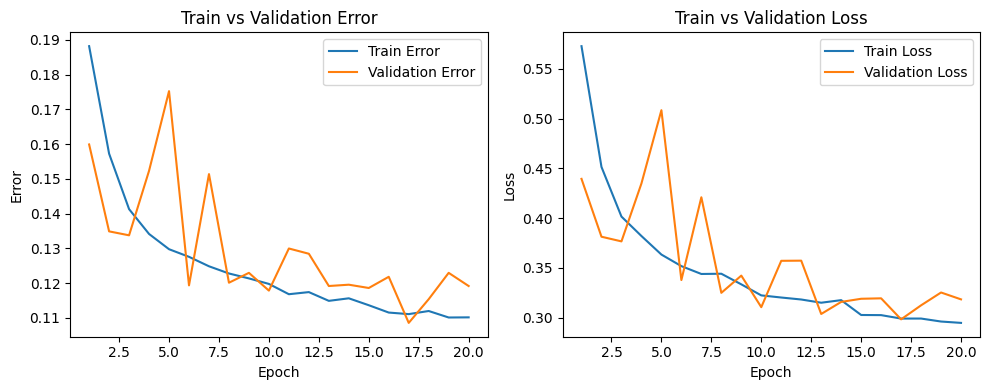

✓ Training complete!


In [12]:

ptb_signals, ptb_labels_dl = load_ptbxl_signals()
mitdb_signals, mitdb_labels_dl = load_mitdb_signals()

all_signals = ptb_signals + mitdb_signals
all_labels_dl = ptb_labels_dl + mitdb_labels_dl

print(f"\nTotal: {len(all_signals)} signals")

BATCH_SIZE = 32
LEARNING_RATE = 0.0001 
NUM_EPOCHS = 20

dl_train_loader, dl_val_loader, dl_test_loader, label_encoder = get_dl_data_loaders(
    all_signals, all_labels_dl, batch_size=BATCH_SIZE
)

model = CNNTransformerECG(num_classes=4)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

train_err, val_err, train_loss, val_loss = train(
    model, dl_train_loader, dl_val_loader,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    name="ecg_cnn_transformer"
)

model_path = get_model_name("ecg_cnn_transformer", BATCH_SIZE, LEARNING_RATE, NUM_EPOCHS)
plot_training_curve(model_path)

print("✓ Training complete!")



# Checking Test data accuracy

In [13]:
def get_accuracy(model, data_loader):
    """Calculate accuracy on a dataset."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for signals, labels in data_loader:
            signals, labels = signals.to(device), labels.to(device)
            outputs = model(signals)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

test_acc = get_accuracy(model, dl_test_loader)
print(f"Test Accuracy: {test_acc:.2f}%")


Test Accuracy: 88.25%


### Since our Test accuracy for our current Data Source is not bad I think the next best step would be to find more data to traint it with and as I wasn't able to find enough data for Afib earlier I need to find more data for that as well

In [24]:
CHALLENGE_PATH = "C:/Users/sharm/OneDrive/Desktop/Ece344/af-classification-challenge-2017-1.0.0/af-classification-from-a-short-single-lead-ecg-recording-the-physionet-computing-in-cardiology-challenge-2017-1.0.0/"
STDB_PATH = "C:/Users/sharm/OneDrive/Desktop/Ece344/mit-bih-st-change-database-1.0.0/mit-bih-st-change-database-1.0.0/"

# Traning Baseline Again with more data

In [25]:
def load_challenge2017_data():
    """
    Load PhysioNet Challenge 2017 with FEATURE EXTRACTION for baseline model.
    Returns handcrafted features (not raw signals).
    """
    print("\n" + "=" * 80)
    print("LOADING PHYSIONET CHALLENGE 2017 DATASET (FEATURES)")
    print("=" * 80)
    
    reference = pd.read_csv(CHALLENGE_PATH + 'REFERENCE-v3.csv', 
                           names=['filename', 'label_code'])
    
    label_mapping = {
        'N': 'Normal',
        'A': 'AFib',
        'O': None,  
        '~': None   
    }
    
    reference['label'] = reference['label_code'].map(label_mapping)
    reference_filtered = reference.dropna()
    
    print(f"Found {len(reference_filtered)} usable records")
    print("\nClass distribution:")
    print(reference_filtered['label'].value_counts())
    
    print("\nProcessing signals and extracting features...")
    features, labels = [], []
    
    for idx, row in reference_filtered.iterrows():
        try:
            filename = row['filename']
            
            record = wfdb.rdrecord(CHALLENGE_PATH + 'training2017/training2017/' + filename)
            ecg_signal = record.p_signal.flatten()
            
            resampled = resample_signal(ecg_signal, original_fs=300, target_fs=100)
            filtered = bandpass_filter(resampled, fs=100)
            normalized = normalize_zscore(filtered)
            
            segments = segment_ecg(normalized, window_size=10, fs=100)
            
            for segment in segments:
                feat = extract_ecg_features(segment, fs=100)
                features.append(list(feat.values()))
                labels.append(row['label'])
            
            if len(features) % 1000 == 0:
                print(f"  Processed {len(features)} segments...")
                
        except Exception as e:
            continue
    
    print(f"✓ Challenge 2017 complete: {len(features)} segments")
    return features, labels


def load_stdb_data():
    """
    Load MIT-BIH ST Change Database with FEATURE EXTRACTION for baseline model.
    Same format as MIT-BIH Arrhythmia - should work perfectly!
    """
    print("\n" + "=" * 80)
    print("LOADING MIT-BIH ST CHANGE DATABASE (FEATURES)")
    print("=" * 80)
    
    # All ST Change Database records (300-series)
    stdb_records = [
        '300', '301', '302', '303', '304', '305', '306', '307', '308', '309',
        '310', '311', '312', '313'
    ]
    
    print(f"Processing {len(stdb_records)} STDB records...")
    features, labels = [], []
    successful_records = 0
    
    for record_name in stdb_records:
        try:
            record = wfdb.rdrecord(STDB_PATH + record_name)
            annotation = wfdb.rdann(STDB_PATH + record_name, 'atr')
            
            ecg_signal = record.p_signal[:, 0]
            
            # Resample from 360 Hz to 100 Hz (same as MIT-BIH)
            resampled = resample_signal(ecg_signal, original_fs=360, target_fs=100)
            filtered = bandpass_filter(resampled, fs=100)
            normalized = normalize_zscore(filtered)
            r_peaks = detect_r_peaks(normalized, fs=100)
            
            window_samples = 10 * 100
            
            annotation_samples = np.array(annotation.sample)
            annotation_symbols = np.array(annotation.symbol)
            
            segments_added = 0
            
            for peak in r_peaks[::5]:
                start = max(0, peak - window_samples // 2)
                end = min(len(normalized), peak + window_samples // 2)
                
                if end - start == window_samples:
                    segment = normalized[start:end]
                    
                    # Convert to original sampling rate for annotation matching
                    start_sample_original = int(start * 360 / 100)
                    end_sample_original = int(end * 360 / 100)
                    
                    mask = (annotation_samples >= start_sample_original) & \
                           (annotation_samples < end_sample_original)
                    segment_annotations = annotation_symbols[mask]
                    
                    if len(segment_annotations) > 0:
                        unique, counts = np.unique(segment_annotations, return_counts=True)
                        dominant_annotation = unique[np.argmax(counts)]
                        label = map_mitdb_annotation(dominant_annotation)  # Use same mapping as MIT-BIH!
                        
                        if label:
                            feat = extract_ecg_features(segment, fs=100)
                            features.append(list(feat.values()))
                            labels.append(label)
                            segments_added += 1
            
            if segments_added > 0:
                successful_records += 1
                print(f"  ✓ {record_name}: {segments_added} segments")
            else:
                print(f"  ✗ {record_name}: no valid segments")
                
        except Exception as e:
            print(f"  ✗ Skipping {record_name}: {str(e)[:80]}")
            continue
    
    print(f"\n✓ STDB complete: {len(features)} segments from {successful_records}/{len(stdb_records)} records")
    return features, labels

In [26]:
ptb_features, ptb_labels = load_ptbxl_data()
mitdb_features, mitdb_labels = load_mitdb_data()
challenge_features, challenge_labels = load_challenge2017_data()
stdb_features, stdb_labels = load_stdb_data() 

# Combine all features
X_all = np.array(ptb_features + mitdb_features + challenge_features + stdb_features)
y_all = np.array(ptb_labels + mitdb_labels + challenge_labels + stdb_labels)

print(f"\n{'='*80}")
print(f"TOTAL COMBINED DATASET (FOR BASELINE MODEL)")
print(f"{'='*80}")
print(f"Total samples: {len(X_all)}")
print(f"  PTB-XL:      {len(ptb_features):6d} ({len(ptb_features)/len(X_all)*100:5.1f}%)")
print(f"  MIT-BIH:     {len(mitdb_features):6d} ({len(mitdb_features)/len(X_all)*100:5.1f}%)")
print(f"  Challenge17: {len(challenge_features):6d} ({len(challenge_features)/len(X_all)*100:5.1f}%)")
print(f"  AFDB:        {len(stdb_features):6d} ({len(stdb_features)/len(X_all)*100:5.1f}%)")

print(f"\nClass distribution:")
unique, counts = np.unique(y_all, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"  {cls:10s}: {cnt:6d} ({cnt/len(y_all)*100:5.1f}%)")

# Create data loaders (same as before - use your existing function)
train_loader, val_loader, test_loader, classes, train_idx, val_idx, test_idx = get_data_loaders(
    X_all, y_all, batch_size=64
)

X_train = X_all[train_idx]
y_train = y_all[train_idx]
X_val = X_all[val_idx]
y_val = y_all[val_idx]
X_test = X_all[test_idx]
y_test = y_all[test_idx]


LOADING PTB-XL DATASET
Loaded 21837 records


C:\Users\sharm\AppData\Local\Temp\ipykernel_13524\3386350937.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ptb_filtered['label'] = ptb_filtered.target_class.apply(lambda x: x[0])


Filtered to 15490 single-label records

Class distribution:
label
Normal    9113
MI        3685
BBB       2692
Name: count, dtype: int64

Processing signals...
  Processed 1000 segments...
  Processed 2000 segments...
  Processed 3000 segments...
  Processed 4000 segments...
  Processed 5000 segments...
  Processed 6000 segments...
  Processed 7000 segments...
  Processed 8000 segments...
  Processed 9000 segments...
  Processed 10000 segments...
  Processed 11000 segments...
  Processed 12000 segments...
  Processed 13000 segments...
  Processed 14000 segments...
  Processed 15000 segments...
✓ PTB-XL complete: 15490 segments

LOADING MIT-BIH DATASET
Processing signals...
✓ MIT-BIH complete: 19695 segments

LOADING PHYSIONET CHALLENGE 2017 DATASET (FEATURES)
Found 5834 usable records

Class distribution:
label
Normal    5076
AFib       758
Name: count, dtype: int64

Processing signals and extracting features...
  Processed 2000 segments...
  Processed 5000 segments...
  Processed 7000

In [ ]:
print("\n" + "=" * 80)
print("TRAINING BASELINE MODEL (EXPANDED DATASET)")
print("=" * 80)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED, 
                          multi_class='multinomial', solver='lbfgs')

print("Training Logistic Regression...")
start_time = time.time()
model.fit(X_train_scaled, y_train)
train_time = time.time() - start_time

print(f"✓ Training complete ({train_time:.2f}s)")

# Evaluate
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
train_f1 = f1_score(y_train, y_pred_train, average='weighted')
test_f1 = f1_score(y_test, y_pred_test, average='weighted')

print(f"\nResults: ")
print(f"  Train Accuracy: {train_acc:.4f}")
print(f"  Test Accuracy: {test_acc:.4f}")
print(f"  Train F1: {train_f1:.4f}")
print(f"  Test F1: {test_f1:.4f}")

print("\nPer-class Performance:")
print(classification_report(y_test, y_pred_test))


TRAINING BASELINE MODEL (EXPANDED DATASET)
Training Logistic Regression...
✓ Training complete (0.19s)


c:\Users\sharm\OneDrive\Desktop\Ece344\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Results (EXPANDED DATASET):
  Train Accuracy: 0.8420
  Test Accuracy: 0.8475
  Train F1: 0.7763
  Test F1: 0.7846

Per-class Performance:
              precision    recall  f1-score   support

        AFib       0.58      0.11      0.18       427
         BBB       0.00      0.00      0.00       397
          MI       0.00      0.00      0.00       572
      Normal       0.85      1.00      0.92      7674

    accuracy                           0.85      9070
   macro avg       0.36      0.28      0.27      9070
weighted avg       0.75      0.85      0.78      9070



c:\Users\sharm\OneDrive\Desktop\Ece344\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\sharm\OneDrive\Desktop\Ece344\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\sharm\OneDrive\Desktop\Ece344\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

# Training the Actual Model

In [29]:
def load_challenge2017_signals():
    """Load PhysioNet Challenge 2017 raw signals for CNN-Transformer."""
    print("\n" + "=" * 80)
    print("LOADING PHYSIONET CHALLENGE 2017 RAW SIGNALS")
    print("=" * 80)
    
    reference = pd.read_csv(CHALLENGE_PATH + 'REFERENCE-v3.csv', 
                           names=['filename', 'label_code'])
    
    label_mapping = {
        'N': 'Normal',
        'A': 'AFib',
        'O': None,  
        '~': None  
    }
    
    reference['label'] = reference['label_code'].map(label_mapping)
    reference_filtered = reference.dropna()
    
    print(f"Found {len(reference_filtered)} usable records")
    print("\nClass distribution:")
    print(reference_filtered['label'].value_counts())
    
    print("\nProcessing signals...")
    signals, labels = [], []
    
    for idx, row in reference_filtered.iterrows():
        try:
            filename = row['filename']
            
            record = wfdb.rdrecord(CHALLENGE_PATH + 'training2017/training2017/' + filename)
            ecg_signal = record.p_signal.flatten()
            
            resampled = resample_signal(ecg_signal, original_fs=300, target_fs=100)
            filtered = bandpass_filter(resampled, fs=100)
            normalized = normalize_zscore(filtered)
            
            segments = segment_ecg(normalized, window_size=10, fs=100)
            
            for segment in segments:
                signals.append(segment)
                labels.append(row['label'])
            
            if len(signals) % 1000 == 0:
                print(f"  Processed {len(signals)} segments...")
                
        except Exception as e:
            continue
    
    print(f"✓ Challenge 2017 complete: {len(signals)} segments")
    return signals, labels

def load_stdb_signals():
    """Load MIT-BIH ST Change Database raw signals for CNN-Transformer."""
    print("\n" + "=" * 80)
    print("LOADING MIT-BIH ST CHANGE DATABASE (RAW SIGNALS)")
    print("=" * 80)
    
    stdb_records = [
        '300', '301', '302', '303', '304', '305', '306', '307', '308', '309',
        '310', '311', '312', '313', '314', '315', '316', '317', '318', '319',
        '320', '321', '322', '323', '324', '325', '326', '327'
    ]
    
    print(f"Processing {len(stdb_records)} STDB records...")
    signals, labels = [], []
    successful_records = 0
    
    for record_name in stdb_records:
        try:
            record = wfdb.rdrecord(STDB_PATH + record_name)
            annotation = wfdb.rdann(STDB_PATH + record_name, 'atr')
            
            ecg_signal = record.p_signal[:, 0]
            
            resampled = resample_signal(ecg_signal, original_fs=360, target_fs=100)
            filtered = bandpass_filter(resampled, fs=100)
            normalized = normalize_zscore(filtered)
            r_peaks = detect_r_peaks(normalized, fs=100)
            
            window_samples = 10 * 100
            
            annotation_samples = np.array(annotation.sample)
            annotation_symbols = np.array(annotation.symbol)
            
            segments_added = 0
            
            for peak in r_peaks[::5]:
                start = max(0, peak - window_samples // 2)
                end = min(len(normalized), peak + window_samples // 2)
                
                if end - start == window_samples:
                    segment = normalized[start:end]
                    
                    start_sample_original = int(start * 360 / 100)
                    end_sample_original = int(end * 360 / 100)
                    
                    mask = (annotation_samples >= start_sample_original) & \
                           (annotation_samples < end_sample_original)
                    segment_annotations = annotation_symbols[mask]
                    
                    if len(segment_annotations) > 0:
                        unique, counts = np.unique(segment_annotations, return_counts=True)
                        dominant_annotation = unique[np.argmax(counts)]
                        label = map_mitdb_annotation(dominant_annotation)
                        
                        if label:
                            signals.append(segment)
                            labels.append(label)
                            segments_added += 1
            
            if segments_added > 0:
                successful_records += 1
                print(f"  ✓ {record_name}: {segments_added} segments")
            
            if len(signals) % 500 == 0 and len(signals) > 0:
                print(f"  Total processed: {len(signals)} segments...")
                
        except Exception as e:
            print(f"  ✗ Skipping {record_name}: {str(e)[:80]}")
            continue
    
    print(f"\n✓ STDB complete: {len(signals)} segments from {successful_records}/{len(stdb_records)} records")
    return signals, labels


LOADING PTB-XL RAW SIGNALS
Processing 15490 records...
  Processed 1000 segments...
  Processed 2000 segments...
  Processed 3000 segments...
  Processed 4000 segments...
  Processed 5000 segments...
  Processed 6000 segments...
  Processed 7000 segments...
  Processed 8000 segments...
  Processed 9000 segments...
  Processed 10000 segments...
  Processed 11000 segments...
  Processed 12000 segments...
  Processed 13000 segments...
  Processed 14000 segments...
  Processed 15000 segments...
✓ PTB-XL complete: 15490 segments

LOADING MIT-BIH RAW SIGNALS
Processing signals...
✓ MIT-BIH complete: 19695 segments

LOADING PHYSIONET CHALLENGE 2017 RAW SIGNALS
Found 5834 usable records

Class distribution:
label
Normal    5076
AFib       758
Name: count, dtype: int64

Processing signals...
  Processed 2000 segments...
  Processed 5000 segments...
  Processed 7000 segments...
  Processed 8000 segments...
  Processed 11000 segments...
  Processed 17000 segments...
✓ Challenge 2017 complete: 18

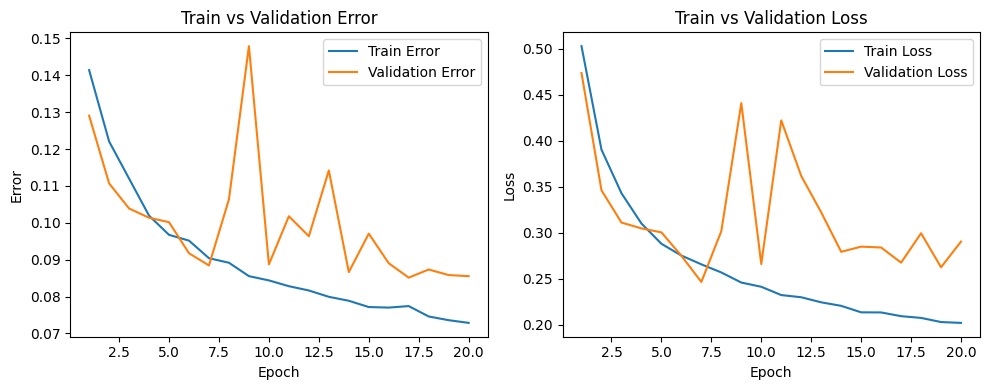

✓ Training complete!


In [34]:
ptb_signals, ptb_labels_dl = load_ptbxl_signals()
mitdb_signals, mitdb_labels_dl = load_mitdb_signals()

challenge_signals, challenge_labels = load_challenge2017_signals()
stdb_signals, stdb_labels = load_stdb_signals()

all_signals = ptb_signals + mitdb_signals + challenge_signals + stdb_signals
all_labels_dl = ptb_labels_dl + mitdb_labels_dl + challenge_labels + stdb_labels

BATCH_SIZE = 64
LEARNING_RATE = 0.0001 
NUM_EPOCHS = 20

dl_train_loader, dl_val_loader, dl_test_loader, label_encoder = get_dl_data_loaders(
    all_signals, all_labels_dl, batch_size=BATCH_SIZE
)


model2 = CNNTransformerECG(num_classes=4)
model = model2
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

train_err, val_err, train_loss, val_loss = train(
    model, dl_train_loader, dl_val_loader,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    name="ecg_cnn_transformer_all_datasets"
)


model_path = get_model_name("ecg_cnn_transformer_all_datasets", BATCH_SIZE, LEARNING_RATE, NUM_EPOCHS)
plot_training_curve(model_path)

print("✓ Training complete!")

In [35]:
test_acc = get_accuracy(model, dl_test_loader)
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 91.59%


# Using a completely new Dataset to test the model and see the accuracy

In [39]:
def load_chapman_test_signals():
    """
    Load Chapman-Shaoxing dataset for testing.
    Maps SNOMED CT diagnosis codes 4 classes.
    """
    
    CHAPMAN_PATH = "C:/Users/sharm/OneDrive/Desktop/Ece344/testing_data/"
    
    diagnosis_mapping = {
        '426783006': 'Normal',   
        '427393009': 'Normal',  
        
        
        '164889003': 'AFib',    
        '164890007': 'AFib',    
        
        
        '164865005': 'MI',  
        '57054005': 'MI',   
        '164861001': 'MI',  
        '164867002': 'MI',  
        
        
        '59118001': 'BBB',   
        '164909002': 'BBB',  
        '713427006': 'BBB',  
        '713426002': 'BBB',  
        '164912004': 'BBB',  
    }
    
    
    print("Finding all ECG records...")
    hea_files = []
    for root, dirs, files in os.walk(CHAPMAN_PATH):
        for file in files:
            if file.endswith('.hea'):
                hea_files.append(os.path.join(root, file[:-4]))
    
    print(f"Found {len(hea_files)} total records")
    
    signals, labels = [], []
    successful_records = 0
    skipped_no_label = 0
    
    for record_path in hea_files:
        try:
            record = wfdb.rdrecord(record_path)
            
            dx_codes = None
            for comment in record.comments:
                if comment.startswith('Dx:'):
                    dx_codes = comment.split(':')[1].strip().split(',')
                    break
            
            if not dx_codes:
                skipped_no_label += 1
                continue
            
            mapped_labels = []
            for code in dx_codes:
                code = code.strip()
                if code in diagnosis_mapping:
                    mapped_labels.append(diagnosis_mapping[code])
            
            if len(mapped_labels) == 0:
                skipped_no_label += 1
                continue
            
            label = max(set(mapped_labels), key=mapped_labels.count)
            
            ecg_signal = record.p_signal[:, 0]
            
            resampled = resample_signal(ecg_signal, original_fs=500, target_fs=100)
            filtered = bandpass_filter(resampled, fs=100)
            normalized = normalize_zscore(filtered)
            
            segments = segment_ecg(normalized, window_size=10, fs=100)
            
            for segment in segments:
                signals.append(segment)
                labels.append(label)
            
            successful_records += 1
            
            if successful_records % 500 == 0:
                print(f"  Processed {successful_records} records, {len(signals)} segments...")
                
        except Exception as e:
            continue
    
    print(f"\n✓ Chapman-Shaoxing complete:")
    print(f"  Total records found: {len(hea_files)}")
    print(f"  Successfully processed: {successful_records}")
    print(f"  Skipped (no valid label): {skipped_no_label}")
    print(f"  Total segments: {len(signals)}")
    return signals, labels

In [40]:
chapman_signals, chapman_labels = load_chapman_test_signals()

chapman_dataset = ECGSignalDataset(
    chapman_signals, 
    chapman_labels, 
    label_encoder,  
    augment=False   
)

chapman_loader = DataLoader(chapman_dataset, batch_size=32, shuffle=False)

Finding all ECG records...
Found 45152 total records
  Processed 500 records, 500 segments...
  Processed 1000 records, 1000 segments...
  Processed 1500 records, 1500 segments...
  Processed 2000 records, 2000 segments...
  Processed 2500 records, 2500 segments...
  Processed 3000 records, 3000 segments...
  Processed 3500 records, 3500 segments...
  Processed 4000 records, 4000 segments...
  Processed 4500 records, 4500 segments...
  Processed 5000 records, 5000 segments...
  Processed 5500 records, 5500 segments...
  Processed 6000 records, 6000 segments...
  Processed 6500 records, 6500 segments...
  Processed 7000 records, 7000 segments...
  Processed 7500 records, 7500 segments...
  Processed 8000 records, 8000 segments...
  Processed 8500 records, 8500 segments...
  Processed 9000 records, 9000 segments...
  Processed 9500 records, 9500 segments...
  Processed 10000 records, 10000 segments...
  Processed 10500 records, 10500 segments...
  Processed 11000 records, 11000 segments.

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in chapman_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

chapman_accuracy = 100 * correct / total
print(f"\n✓ Chapman-Shaoxing Test Accuracy: {chapman_accuracy:.2f}%")

# Per-class performance
print("\nPer-class Performance on Chapman-Shaoxing:")
print(classification_report(
    all_labels, 
    all_preds, 
    target_names=label_encoder.classes_,
    digits=4
))

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:")
print("              ", "  ".join([f"{cls:6s}" for cls in label_encoder.classes_]))
for i, cls in enumerate(label_encoder.classes_):
    print(f"{cls:10s}:", "  ".join([f"{cm[i,j]:6d}" for j in range(len(label_encoder.classes_))]))



✓ Chapman-Shaoxing Test Accuracy: 54.69%

Per-class Performance on Chapman-Shaoxing:
              precision    recall  f1-score   support

        AFib     0.9299    0.1420    0.2463      9813
         BBB     0.3018    0.6304    0.4081      1304
          MI     0.0089    0.4386    0.0175       114
      Normal     0.8136    0.9268    0.8665     10205

    accuracy                         0.5469     21436
   macro avg     0.5136    0.5344    0.3846     21436
weighted avg     0.8314    0.5469    0.5502     21436


Confusion Matrix:
               AFib    BBB     MI      Normal
AFib      :   1393    1758    4848    1814
BBB       :     51     822     120     311
MI        :     12      10      50      42
Normal    :     42     134     571    9458
